In [2]:
# load data
data = load_dataset(0, 10)
spikes = data['spks']
wheel = data['wheel']

In [45]:
from tqdm.auto import trange
import numpy as np
import matplotlib.pyplot as plt
from src.data_loader import load_dataset

In [115]:
def corr_emph(x,y):
    xx = x - np.mean(x)
    yy = y - np.mean(y)
    return np.sum(xx*yy) / np.sqrt(np.sum(xx**2) * np.sum(yy**2))

def xcorr(x, y, maxLag):
    lags = np.arange(-maxLag, maxLag+1)
    cc = np.zeros_like(lags, dtype=np.double)
    cc[maxLag] = corr_emph(x, y)
    for k in np.arange(-maxLag, 0):
        cc[maxLag+k] = corr_emph(x[-k:], y[:k])
    for k in np.arange(1, maxLag+1):
        cc[maxLag+k] = corr_emph(x[:-k], y[k:])
    return cc

def corr(x, y):
    xx = x-np.mean(x, axis=0)
    yy = y-np.mean(y, axis=0)
    return np.sum(xx*yy, axis=0) / (np.sqrt(np.sum(xx**2, axis=0) * np.sum(yy**2, axis=0))+1e-6)

def xcorr_fast(x, y, n_lags):
    results = np.zeros((2*n_lags+1, *x.shape[1:]), dtype=np.double)
    #print(x.shape, results.shape)
    for i, lag in enumerate(trange(-n_lags, n_lags+1, desc='lag')):
        results[i] = corr(np.roll(x, lag, axis=0), y)
    return results

In [90]:
print(spikes.shape, np.roll(spikes, 1, axis=-1).shape)

(857, 342, 250) (857, 342, 250)


In [118]:
tile = np.tile(np.abs(wheel), (spikes.shape[0],1,1))
print(tile.shape, tile.T.shape, spikes.shape, spikes.T.shape)
cross_corr = xcorr_fast(spikes.T, tile.T, 100)

(857, 342, 250) (250, 342, 857) (857, 342, 250) (250, 342, 857)


lag:   0%|          | 0/201 [00:00<?, ?it/s]C:\Users\matte\AppData\Local\Temp\ipykernel_5772\4049377906.py:19: RuntimeWarning: invalid value encountered in divide
  return np.sum(xx*yy, axis=0) / np.sqrt(np.sum(xx**2, axis=0) * np.sum(yy**2, axis=0))
lag: 100%|██████████| 201/201 [04:18<00:00,  1.29s/it]


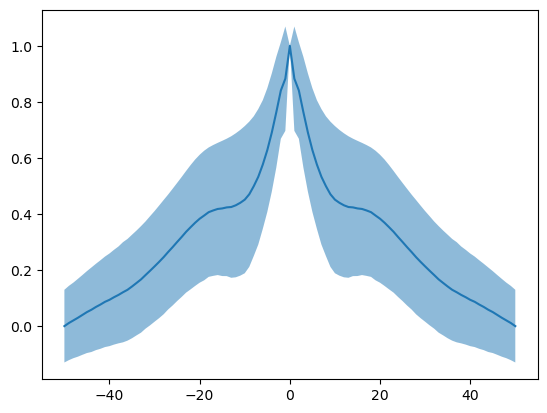

In [117]:
cc = cross_corr.T
t = np.arange(-50, 51)
mean = np.nanmean(cc, axis=1)
std = np.nanstd(cc, axis=1)
neuron=101
plt.figure()
plt.plot(t, mean[neuron])
plt.fill_between(t, (mean-std)[neuron], (mean+std)[neuron], alpha=0.5)


['CP' 'LSc' 'LSr' 'MOp' 'PT' 'root']


C:\Users\matte\AppData\Local\Temp\ipykernel_5772\725796102.py:3: RuntimeWarning: Mean of empty slice
  cc = np.nanmean(cross_corr.T[MOp], axis=1)
C:\Users\matte\AppData\Local\Temp\ipykernel_5772\725796102.py:4: RuntimeWarning: All-NaN slice encountered
  srt = np.argsort(np.nanmax(cc, axis=1))[::-1]


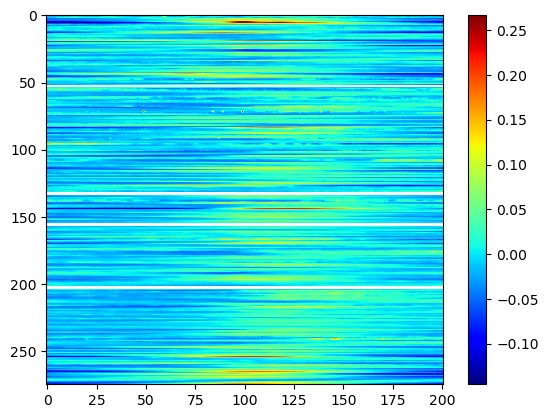

In [130]:
MOp = data['brain_area']=='CP'
print(np.unique(data['brain_area']))
cc = np.nanmean(cross_corr.T[MOp], axis=1)
srt = np.argsort(np.nanmax(cc, axis=1))[::-1]
plt.figure()
plt.imshow(cc, 'jet', aspect='auto')
plt.colorbar()
#plt.ylim(100, 0)


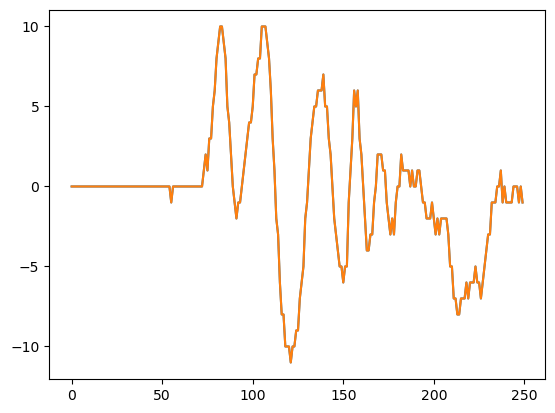

In [75]:
r = np.tile(wheel, (45,1,1))
plt.figure()
plt.plot(r[0,0])
plt.plot(r[1,0])

In [53]:
n_lags = 20
results = np.zeros((spikes.shape[0], spikes.shape[1], 2*n_lags+1))
for neuron in trange(50, desc='neuron'):
    for trial in range(spikes.shape[1]):
        x = xcorr(spikes[neuron, trial], np.abs(wheel[0, trial]), n_lags)
        results[neuron, trial] = x

neuron:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\matte\AppData\Local\Temp\ipykernel_5772\4038217282.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(xx*yy) / np.sqrt(np.sum(xx**2) * np.sum(yy**2))
neuron: 100%|██████████| 50/50 [00:29<00:00,  1.72it/s]


In [34]:
results = np.zeros((spikes.shape[0], spikes.shape[1], spikes.shape[2]))
for neuron in trange(spikes.shape[0], desc='neuron'):
    for trial in range(spikes.shape[1]):
        x = np.correlate(spikes[neuron, trial], wheel[0, trial], mode='same')
        results[neuron, trial] = x

neuron: 100%|██████████| 857/857 [00:09<00:00, 95.17it/s]


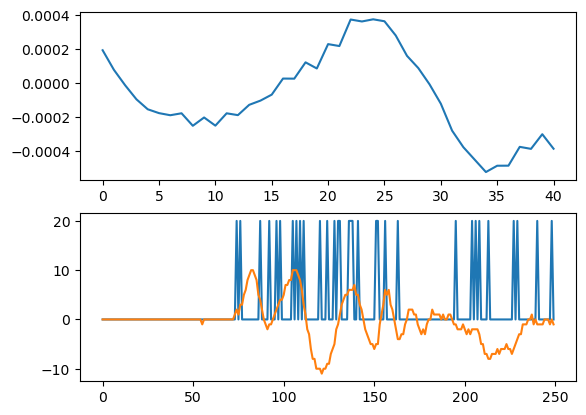

In [52]:
f, ax = plt.subplots(2,1)
neuron, trial = 24,0
ax[0].plot(results[neuron, trial]/250)
ax[1].plot(spikes[neuron,trial]*20)
ax[1].plot(wheel[0,trial])

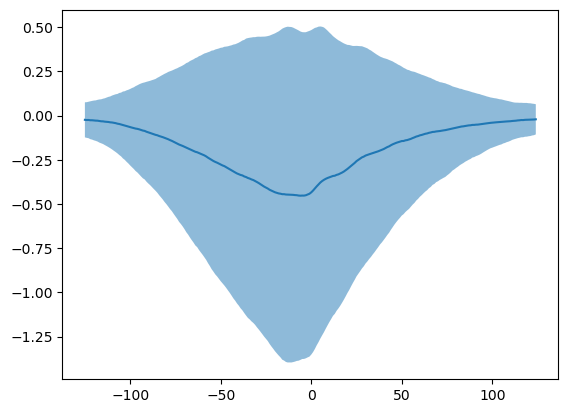

In [32]:
plt.figure()
neuron=435
t=np.arange(-125,125)
T = results.shape[-1]
plt.plot(t, results[neuron].mean(0)/T)
plt.fill_between(t, (results[neuron].mean(0)-results[neuron].std(0))/T, (results[neuron].mean(0)+results[neuron].std(0))/T, alpha=0.5)

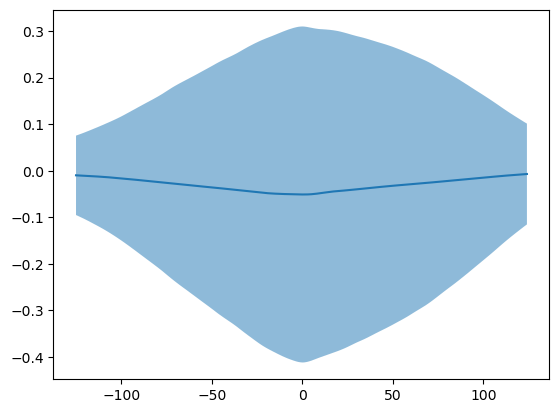

In [24]:
plt.figure()
t=np.arange(-125,125)
T = results.shape[-1]
mean = (results/T).mean((0,1))
std = (results/T).std((0,1))
plt.plot(t, mean)
plt.fill_between(t, mean-std,mean+std, alpha=0.5)

(430.0, 450.0)

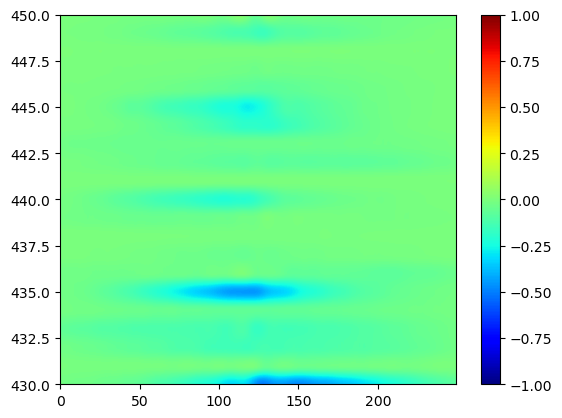

In [31]:
plt.figure()
plt.imshow(results.mean(1)/T, aspect='auto', vmin=-1, vmax=1,cmap='jet')
plt.colorbar()
plt.ylim([430,450])

In [60]:
results_mean = np.zeros((spikes.shape[1], 251))
mean_firing = spikes.mean(0)/0.01
for trial in trange(spikes.shape[1], desc='trial'):
    x = xcorr(mean_firing[trial], np.abs(wheel[0, trial]), 125)
    results_mean[trial] = x

trial:  68%|██████▊   | 234/342 [00:02<00:01, 104.74it/s]C:\Users\matte\AppData\Local\Temp\ipykernel_5772\4038217282.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(xx*yy) / np.sqrt(np.sum(xx**2) * np.sum(yy**2))
trial: 100%|██████████| 342/342 [00:03<00:00, 106.84it/s]


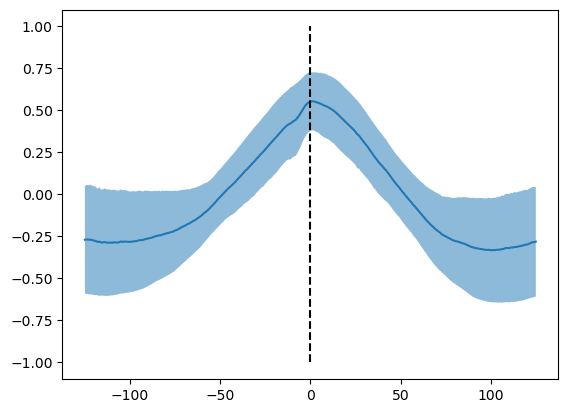

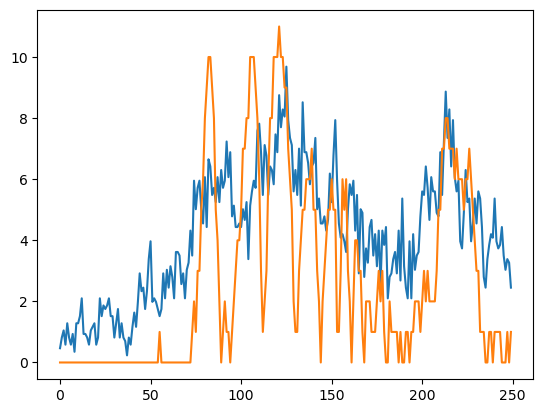

In [63]:
plt.figure()
mean = np.nanmean(results_mean, axis=0)
std = np.nanstd(results_mean, axis=0)
t = np.arange(-125,126)
T = results_mean.shape[-1]
plt.plot(t, mean)
plt.fill_between(t, mean-std,mean+std, alpha=0.5)
plt.vlines(0, -1, 1, colors = 'k', linestyles='dashed')
plt.figure()
plt.plot(mean_firing[0])
plt.plot(np.abs(wheel[0,0]))